In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS ACSM module
from bacs.agents.bacs import BACS, Configuration
from bacs.agents.bacs.utils.GymMazeWrapper import _maze_metrics, parse_metrics_to_df, plot_performance

# Load environments
import gym
import my_mazes

## Agent - BACS

### Common parameters

In [2]:
CLASSIFIER_LENGTH = 8
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Littman89-v0"

NUMBER_OF_EXPLORE_TRIALS = 1000
DO_ACTION_PLANNING_EXPLORE = False
DO_GA_EXPLORE = False
DO_SUBSUMPTION_EXPLORE = True
BETA_EXPLORE = 0.05
EPSILON = 0.8

NUMBER_OF_EXPLOIT_TRIALS = 500
DO_ACTION_PLANNING_EXPLOIT = False
DO_SUBSUMPTION_EXPLOIT = True
BETA_EXPLOIT = 0.00

LENGTH_OF_BEHAVIORAL_SEQUENCES = 1

### Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Reset it, by putting an agent into random position
situation = maze.reset()
# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ □ □ □ □ □ ■ ■
■ □ □ ■ A ■ □ □ ■
■ ■ □ ■ □ ■ □ ■ ■
■ □ □ ■ □ ■ □ $ ■
■ ■ □ □ □ □ □ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


### Training of BACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=DO_GA_EXPLORE,
    do_subsumption=DO_SUBSUMPTION_EXPLORE,
    do_action_planning=DO_ACTION_PLANNING_EXPLORE,
    action_planning_frequency=50,
    beta=BETA_EXPLORE,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 1min 39s, sys: 765 ms, total: 1min 40s
Wall time: 1min 50s


In [5]:
population_explore_to_display = [cl for cl in population_explore if cl.does_anticipate_change()]
for cl in population_explore_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.talp, cl.exp, cl.mark))
    print("\n")

##0#10## 2 None None ##1#01##         (11001001)            q: 0.305 r: 824.1  ir: 0.0    f: 251.3  exp: 210 tga: 4     talp: 26513 tav: 1.98e+02 num: 1


1#10##01 4 None None 0#01##10         (empty)               q: 1.0   r: 902.3  ir: 0.0    f: 902.3  exp: 212 tga: 15    talp: 26452 tav: 1.49e+02 num: 1


0#0#011# 2 None None 1#1#100#         (empty)               q: 0.999 r: 871.7  ir: 0.0    f: 870.5  exp: 107 tga: 17    talp: 26243 tav: 3.06e+02 num: 1


###110#0 7 None None ###001#1         (empty)               q: 0.999 r: 843.5  ir: 0.0    f: 843.0  exp: 118 tga: 18    talp: 26191 tav: 2.69e+02 num: 1


11#11000 5 None None 00#90111         (empty)               q: 1.0   r: 949.8  ir: 0.0    f: 949.8  exp: 192 tga: 31    talp: 26770 tav: 2.36e+02 num: 1


#019#1## 4 None None #191#0##         (empty)               q: 1.0   r: 948.5  ir: 0.0    f: 948.4  exp: 141 tga: 37    talp: 26270 tav: 2.22e+02 num: 1


#19#001# 4 None None #91#110#         (empty)               q: 1.0   r

### Exploitation of BACS

In [6]:
%%time

cfg_exploit = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=DO_SUBSUMPTION_EXPLOIT,
    do_action_planning=DO_ACTION_PLANNING_EXPLOIT,
    action_planning_frequency=50,
    beta=BETA_EXPLOIT,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=1
)

agent_exploit = BACS(cfg_exploit, population_explore)
agent_exploit.clean_population(does_anticipate_change=True)
population_exploit, metrics_exploit = agent_exploit.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS)

CPU times: user 31.7 s, sys: 468 ms, total: 32.2 s
Wall time: 41 s


### Performance

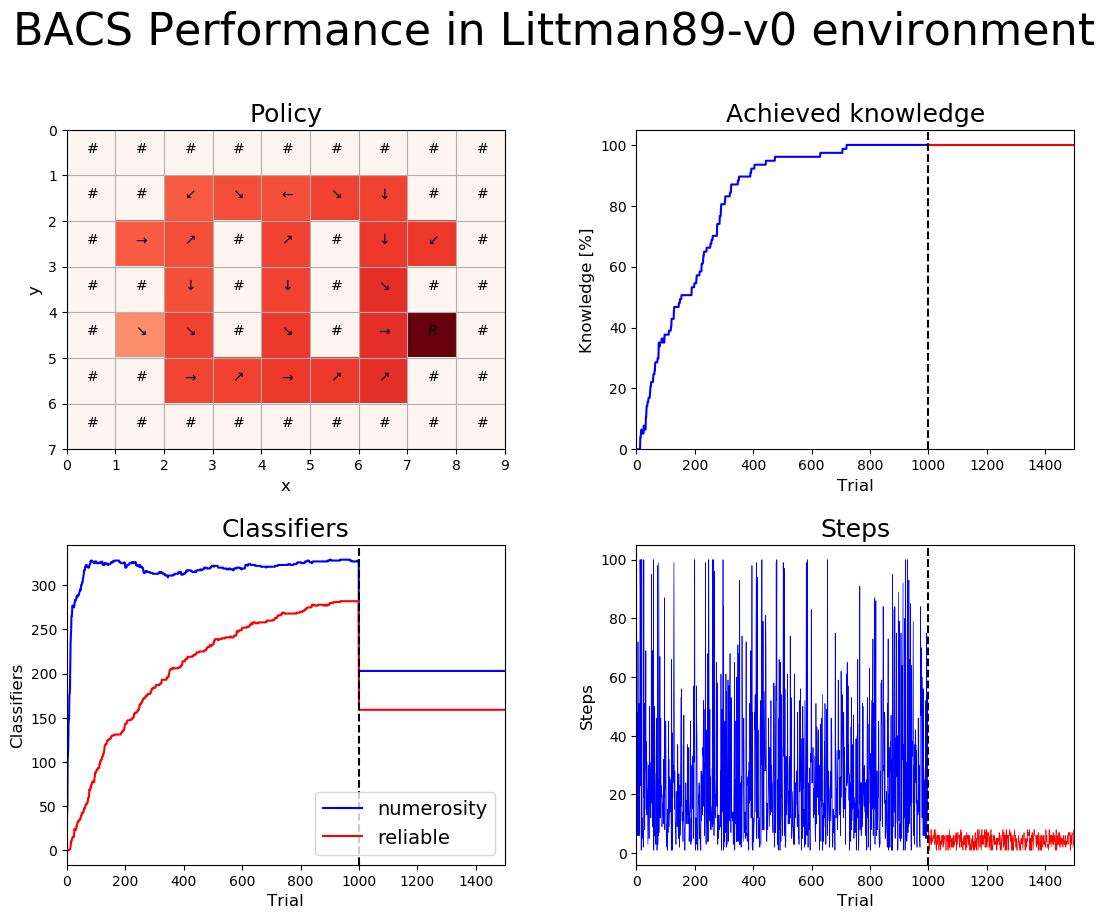

In [7]:
metrics_df = parse_metrics_to_df(metrics_explore, metrics_exploit)
plot_performance(agent_exploit, maze, metrics_df, cfg_exploit, MAZE)

In [8]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS
avg_step_exploit = 0
for trial in metrics_exploit:
    avg_step_exploit += trial['steps_in_trial']
avg_step_exploit /= NUMBER_OF_EXPLOIT_TRIALS
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")
print("Average number of steps to solve the maze is ",avg_step_exploit,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS, " trials in EXPLOITATION")

Average number of steps to solve the maze is  26.81  for a total of  1000  trials in EXPLORATION
Average number of steps to solve the maze is  4.29  for a total of  500  trials in EXPLOITATION


In [9]:
population_exploit.sort(key=lambda cl: -cl.fitness)
population_exploit_to_display = [cl for cl in population_exploit]
for cl in population_exploit_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.num, cl.exp, cl.mark))
    print("\n")

0#9#0#11 2 None None 1#1#1#00         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 403 tga: 41    talp: 26717 tav: 62.1   num: 1


00#90111 3 None None 11#11000         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 347 tga: 345   talp: 26786 tav: 1e+02  num: 1


09###1#1 1 None None 11###0#0         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 224 tga: 52    talp: 26809 tav: 1.3e+02 num: 1


01100011 3 [1] [('1', '0', '0', '1', '1', '1', '0', '0')] ##91####         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 515 tga: 1475  talp: 26808 tav: 41.7   num: 1


#1010##0 4 None None #019###1         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 386 tga: 1770  talp: 26786 tav: 84.1   num: 1


01##1##1 2 [1] [('1', '0', '0', '1', '1', '1', '0', '0')] ##9#001#         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 949.9  exp: 186 tga: 4988  talp: 26502 tav: 1.08e+02 num: 1


11#11